In [132]:
import warnings
import os
from hmmlearn import hmm
import numpy as np
from librosa.feature import mfcc
import librosa
import random
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import get_window

In [133]:
def buildDataSet(dir, rte):
    # Filter out the wav audio files under the dir
    fileList = [f for f in os.listdir(dir) if os.path.splitext(f)[1] == '.wav']
    train_dataset = {}
    test_dataset = {}
    cnt = 1
    # Calculate percent of each train and test
    nm = int(rte * 50)
    rnd = random.sample(range(0, 50), nm)

    for fileName in fileList:
        label = fileName.split('_')[0]
        full_audio_path = os.path.join(dir, fileName)
        feature = extract_mfcc(full_audio_path)
        
        if cnt in rnd:
            if label not in test_dataset:
                test_dataset[label] = []
            test_dataset[label].append(feature)
        else:
            if label not in train_dataset:
                train_dataset[label] = []
            train_dataset[label].append(feature)
        
        if cnt == 50:
            cnt = 1
            rnd = random.sample(range(0, 50), 12)
        else:
            cnt += 1

    return train_dataset, test_dataset

# Fungsi buildDataSet yang Anda berikan adalah untuk membangun dataset pelatihan (train_dataset) dan dataset pengujian (test_dataset) dari file audio dalam direktori yang diberikan. Tujuan dari fungsi ini adalah untuk membagi data audio ke dalam dataset pelatihan dan pengujian dengan proporsi tertentu, serta mengumpulkan fitur-fitur MFCC (Mel-frequency cepstral coefficients) dari setiap file audio.

# Mari kita bahas lebih detail tentang bagaimana fungsi ini bekerja:

# Fungsi menerima dua argumen:

# dir: Direktori di mana file-file audio WAV berada.
# rte: Persentase data yang akan digunakan sebagai dataset pengujian. Misalnya, jika rte adalah 0.2, maka 20% data akan menjadi dataset pengujian.
# Fungsi pertama-tama mencari semua file audio dalam direktori yang memiliki ekstensi .wav menggunakan modul os.

# Sebuah loop dilakukan untuk setiap file audio dalam fileList:

# Nama label diambil dari nama file dengan memisahkan string menggunakan _ dan mengambil bagian pertama.
# Alamat lengkap file audio dibangun dengan menggabungkan dir dan nama file.
# Fitur MFCC diekstraksi dari file audio menggunakan fungsi extract_mfcc. Ini melibatkan pemrosesan audio untuk menghasilkan fitur-fitur yang mewakili karakteristik audio.
# Selanjutnya, dilakukan penentuan apakah audio tersebut akan dimasukkan ke dalam dataset pelatihan atau pengujian:

# Sebuah angka hitungan cnt diinisialisasi dengan nilai 1.
# Sebuah angka acak rnd dipilih dari rentang 0 hingga 50 untuk menentukan apakah audio ini akan menjadi bagian dari dataset pengujian berdasarkan nilai nm (nilai dari rte dikalikan dengan 50). Ini dilakukan untuk memastikan proporsi dataset pengujian sesuai dengan nilai rte.
# Jika cnt termasuk dalam nilai-nilai yang dipilih secara acak (rnd), maka fitur audio akan dimasukkan ke dalam dataset pengujian. Jika tidak, fitur akan dimasukkan ke dalam dataset pelatihan.
# Setelah mengelompokkan fitur-fitur MFCC ke dalam dataset pelatihan dan pengujian sesuai dengan label, dilakukan pengecekan kondisi:

# Jika cnt telah mencapai 50 (artinya telah diproses 50 file audio), cnt diatur kembali menjadi 1 dan angka acak rnd dihasilkan ulang dengan memilih 12 angka acak baru. Ini dilakukan untuk memastikan pola pengujian yang berbeda pada setiap siklus.
# Jika cnt belum mencapai 50, cnt akan ditingkatkan sebesar 1.
# Fungsi mengembalikan dataset pelatihan dan pengujian yang sudah dibangun.

# Jadi, keseluruhan tujuan dari fungsi ini adalah untuk membagi data audio ke dalam dataset pelatihan dan pengujian dengan proporsi tertentu (ditentukan oleh rte), sambil mengumpulkan fitur-fitur MFCC yang diperlukan untuk analisis lebih lanjut.

In [134]:
def extract_mfcc(full_audio_path):
    wave, sample_rate = librosa.load(full_audio_path)
    mfcc_features = librosa.feature.mfcc(y=wave, sr=sample_rate)
    return mfcc_features.T

In [135]:
### Gussian HMM
def train_HMM(dataset):
    Models = {}
    for label in dataset.keys():
        model = hmm.GMMHMM(n_components=10)
        trainData = dataset[label]
        trData = np.vstack(trainData)
        model.fit(trData)
        Models[label] = model
    return Models

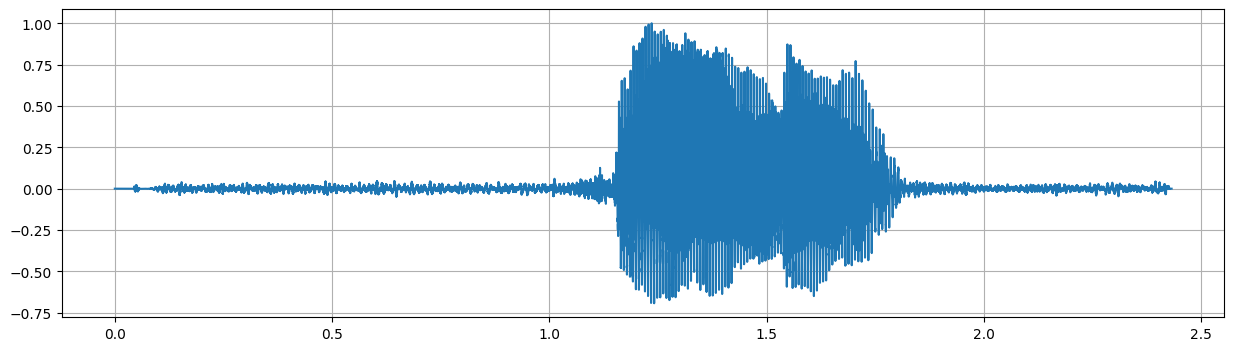

In [136]:
sample_rate, audio = wavfile.read("./new_spoken_digit/halo_10.wav")

# audio normalizing function so that the audio values will be between -1 to 1
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

# normalizing the audio data
audio = normalize_audio(audio)

# plotting the normalized audio data
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

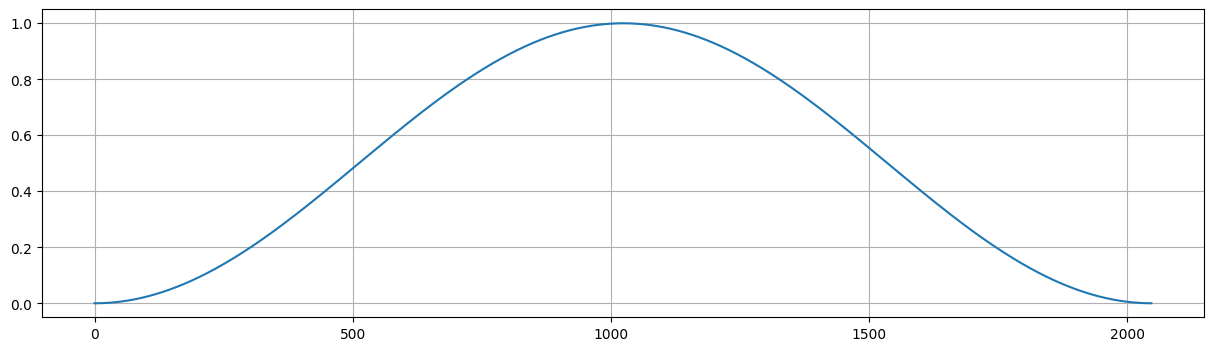

In [137]:
# For simplicity we will choose the Hanning window.
# To make the audio continues, we apply a window function on every frame
# Hann window functions have a sinusoidal shape.
# Hann window touches zero at both ends eliminating all discontinuity
# The window assures that both ends of the signal will end close to zero.
FFT_size = 2048
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

In [138]:
# audio framing fuction to devide the signal into short frames
# hop_size: number of samples between each successive FFT window
# FFT_size: number of bins used for dividing the window into equal strips, or bins

def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

# setting the frame_audio parameters
hop_size = 25 #ms
FFT_size = 2048

# framed audio matrix with the size of frame number X FFT size
# framing the signal we assured the audio to be periodic.
audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (98, 2048)


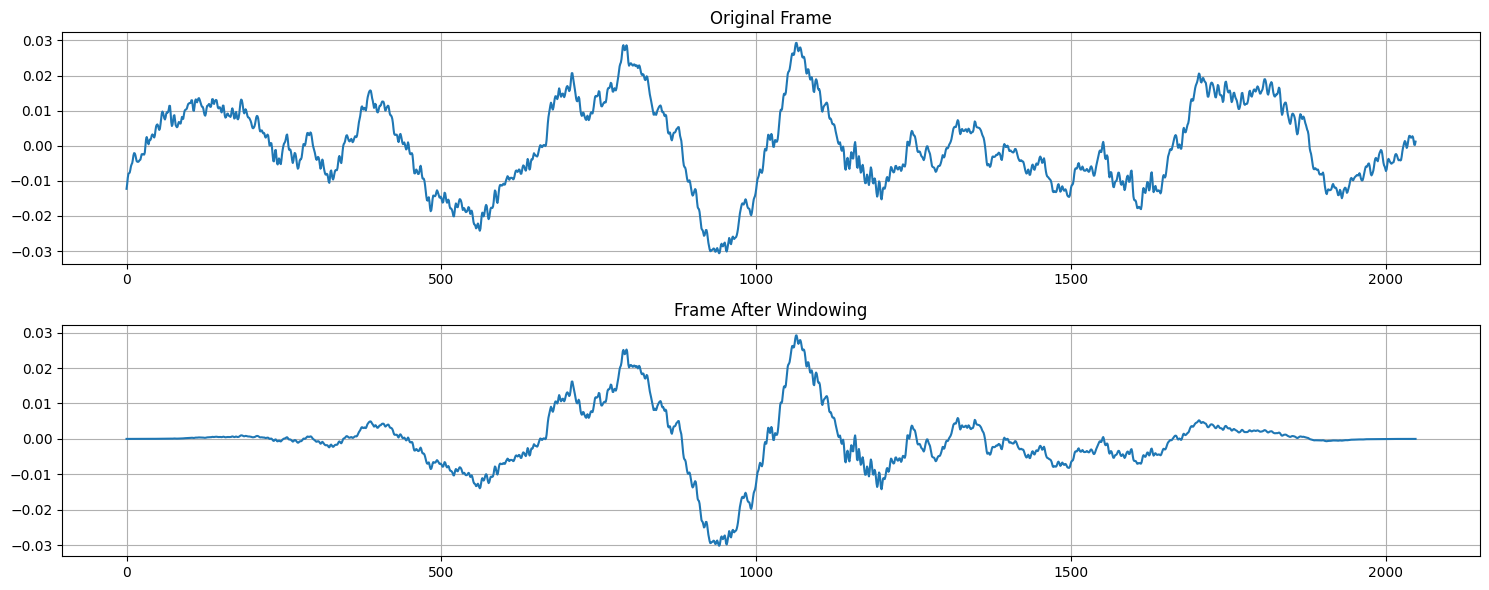

In [139]:


audio_win = audio_framed * window

# Assuming you have defined audio_framed and audio_win arrays
ind = 10  # Choose an index within the valid range of audio_framed

plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

plt.tight_layout()
plt.show()

In [140]:
def main():
    ### ignore warning message of readfile
    warnings.filterwarnings('ignore')

    sample_rate, audio = wavfile.read("./new_spoken_digit/halo_10.wav")
    print("Sample rate: {0}Hz".format(sample_rate))
    print("Audio duration: {0}s".format(len(audio) / sample_rate))

    ### Step.1 Loading data
    trainDir = './new_spoken_digit_back/'
    print('Step.1 data loading...')
    trainDataSet,testDataSet = buildDataSet(trainDir,rte=0.25)
    print("Finish prepare the data")


    ### Step.2 Training
    print('Step.2 Training model...')
    hmmModels = train_HMM(trainDataSet)
    print("Finish training of the GMM_HMM models for digits 0-9")

    ### Step.3 predict test data
    acc_count = 0
    all_data_count = 0
    for label in testDataSet.keys():
        feature = testDataSet[label]
        for index in range(len(feature)):
            all_data_count+=1
            scoreList = {}
            for model_label in hmmModels.keys():
                model = hmmModels[model_label]
                score = model.score(feature[index])
                scoreList[model_label] = score
            predict = max(scoreList, key=scoreList.get)
            if predict == label:
                acc_count+=1

    accuracy = round(((acc_count/all_data_count)*100.0),3)

    print("\n##########################################################################")
    print("######################## A-C-C-U-R-A-C-Y #################################")
    print("########################    ",accuracy,"%","   #################################")
    print("##########################################################################")

In [141]:
if __name__ == '__main__':
    main()

Sample rate: 48000Hz
Audio duration: 2.432s
Step.1 data loading...
Finish prepare the data
Step.2 Training model...
Finish training of the GMM_HMM models for digits 0-9

##########################################################################
######################## A-C-C-U-R-A-C-Y #################################
########################     95.966 %    #################################
##########################################################################
